In [1]:
try:
    import opendatasets as od
except ImportError:
    !pip install opendatasets
    import opendatasets as od

In [2]:
import os
import cv2
import shutil
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

# Prepare data

In [3]:
# Download data using kaggle username/key
od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data")
# od.download("https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection")

Skipping, found downloaded files in "./brain-tumor-mri-dataset" (use force=True to force download)


In [4]:
def move_files(source_dir, destination_dir):
    emptied_dirs = []
    for subdir, dirs, files in os.walk(source_dir):
        for file in files:
            if not subdir.endswith('notumor'):
                tumor_dir = os.path.join(destination_dir, 'tumor')
                if not os.path.exists(tumor_dir):
                    os.makedirs(tumor_dir)
                destination_file = os.path.join(tumor_dir, file)
                if not os.path.exists(destination_file):
                    shutil.move(os.path.join(subdir, file), destination_file)

def remove_empty_folders(directory):
    for root, dirs, files in os.walk(directory, topdown=False):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            if not os.listdir(dir_path):
                os.rmdir(dir_path)


dir = os.path.join(os.getcwd(),"brain-tumor-mri-dataset")

# Move files
move_files(os.path.join(dir, "Testing"), os.path.join(dir, "Testing"))
move_files(os.path.join(dir, "Training"), os.path.join(dir, "Training"))
remove_empty_folders(dir)

In [5]:
# Preprocess the data
def remove_black_border(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        return image[y:y+h, x:x+w]
    else:
        return image

def load_images_resize(file_paths, width=128, height=128, remove_black = False):
    images = []
    for file_path in file_paths:
        try:
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            if remove_black:
                img = remove_black_border(img)
            img = cv2.resize(img, (width, height))
            images.append(img)
        except Exception as e:
            print(f"Error loading image: {file_path} - {e}")
    return np.array(images)

# Define the directory
directory = os.path.join(os.getcwd(), "brain-tumor-mri-dataset")

# Define paths to the directories containing images
training_tumor_dir = os.path.join(directory, "Training", "tumor")
training_notumor_dir = os.path.join(directory, "Training", "notumor")
testing_tumor_dir = os.path.join(directory, "Testing", "tumor")
testing_notumor_dir = os.path.join(directory, "Testing", "notumor")

# Load and resize images
training_tumor_files = [os.path.join(training_tumor_dir, file) for file in os.listdir(training_tumor_dir)]
training_tumor_images = load_images_resize(training_tumor_files)

training_notumor_files = [os.path.join(training_notumor_dir, file) for file in os.listdir(training_notumor_dir)]
training_notumor_images = load_images_resize(training_notumor_files)

testing_tumor_files = [os.path.join(testing_tumor_dir, file) for file in os.listdir(testing_tumor_dir)]
testing_tumor_images = load_images_resize(testing_tumor_files)

testing_notumor_files = [os.path.join(testing_notumor_dir, file) for file in os.listdir(testing_notumor_dir)]
testing_notumor_images = load_images_resize(testing_notumor_files)

# Define training and testing data
X_train = np.concatenate((training_tumor_images, training_notumor_images))
y_train = np.concatenate((np.ones(len(training_tumor_images)), np.zeros(len(training_notumor_images))))

X_test = np.concatenate((testing_tumor_images, testing_notumor_images))
y_test = np.concatenate((np.ones(len(testing_tumor_images)), np.zeros(len(testing_notumor_images))))

# Split combined training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the number of images to keep for training and validation
num_train = 50
num_val = 10

# Select images for training, validation, and testing
X_train = np.concatenate((training_tumor_images[:num_train], training_notumor_images[:num_train]))
y_train = np.concatenate((np.ones(num_train), np.zeros(num_train)))

X_val = np.concatenate((training_tumor_images[num_train:num_train+num_val],
                        training_notumor_images[num_train:num_train+num_val]))
y_val = np.concatenate((np.ones(num_val), np.zeros(num_val)))



In [6]:
print("Training images shape:", X_train.shape)
print("Train label shape", y_train.shape)
print("Validation images shape:", X_val.shape)
print("Validation label shape", y_val.shape)
print("Testing images shape:", X_test.shape)
print("Testing label shape", y_test.shape)

Training images shape: (100, 128, 128, 3)
Train label shape (100,)
Validation images shape: (20, 128, 128, 3)
Validation label shape (20,)
Testing images shape: (1311, 128, 128, 3)
Testing label shape (1311,)


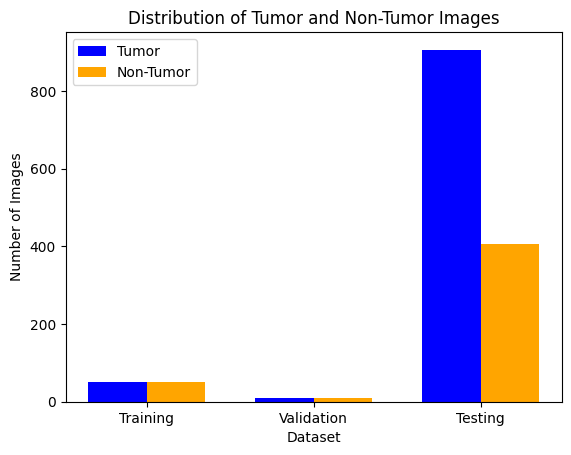

In [7]:
# Define counts for all datasets
train_tumor_count = np.sum(y_train)
train_non_tumor_count = len(y_train) - train_tumor_count

val_tumor_count = np.sum(y_val)
val_non_tumor_count = len(y_val) - val_tumor_count

test_tumor_count = np.sum(y_test)
test_non_tumor_count = len(y_test) - test_tumor_count

# Combine counts for all datasets
tumor_counts = [train_tumor_count, val_tumor_count, test_tumor_count]
non_tumor_counts = [train_non_tumor_count, val_non_tumor_count, test_non_tumor_count]

# Plotting
labels = ['Training', 'Validation', 'Testing']
x = range(len(labels))
width = 0.35

plt.bar(x, tumor_counts, width, label='Tumor', color='blue')
plt.bar([i + width for i in x], non_tumor_counts, width, label='Non-Tumor', color='orange')

plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Distribution of Tumor and Non-Tumor Images')
plt.xticks([i + width/2 for i in x], labels)
plt.legend()
plt.show()


# Resnet

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 31977090 (121.98 MB)
Trainable params: 8389378 (32.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


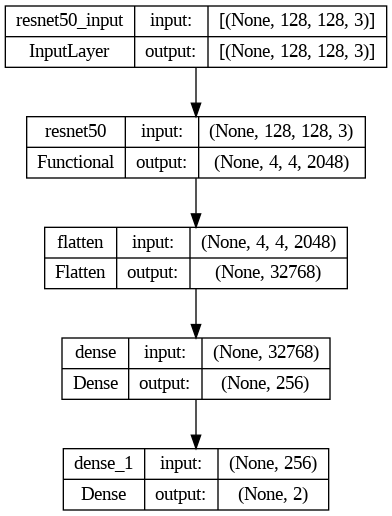

In [8]:
# Define the ResNet model
def create_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (128, 128, 3)
num_classes = 2

resnet_model = create_resnet_model(input_shape, num_classes)

resnet_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

resnet_model.summary()
plot_model(resnet_model, to_file='resnet_model.png', show_shapes=True, show_layer_names=True)

In [9]:
# Train the resnet model
resnet_history = resnet_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
4/4 [==============================] - 7s 592ms/step - loss: 19.5392 - accuracy: 0.5900 - val_loss: 7.1079 - val_accuracy: 0.8000
Epoch 2/10
4/4 [==============================] - 0s 24ms/step - loss: 2.8226 - accuracy: 0.8400 - val_loss: 4.9636 - val_accuracy: 0.8500
Epoch 3/10
4/4 [==============================] - 0s 21ms/step - loss: 1.6519 - accuracy: 0.9100 - val_loss: 5.5754 - val_accuracy: 0.8000
Epoch 4/10
4/4 [==============================] - 0s 21ms/step - loss: 1.0053 - accuracy: 0.9400 - val_loss: 3.6026 - val_accuracy: 0.8500
Epoch 5/10
4/4 [==============================] - 0s 21ms/step - loss: 0.0563 - accuracy: 0.9900 - val_loss: 3.3469 - val_accuracy: 0.8500
Epoch 6/10
4/4 [==============================] - 0s 21ms/step - loss: 7.1526e-09 - accuracy: 1.0000 - val_loss: 3.2133 - val_accuracy: 0.8500
Epoch 7/10
4/4 [==============================] - 0s 21ms/step - loss: 6.3298e-07 - accuracy: 1.0000 - val_loss: 3.2460 - val_accuracy: 0.9000
Epoch 8/10
4/4 [=

In [10]:
resnet_model.save_weights('resnet_model_weights.h5')

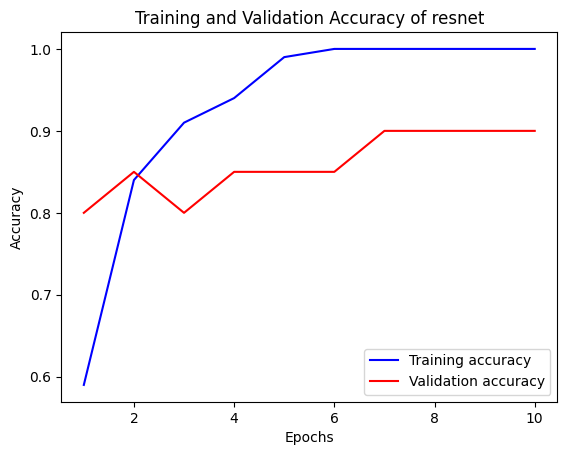

In [11]:
# Accessing accuracy values from the history
train_accuracy = resnet_history.history['accuracy']
val_accuracy = resnet_history.history['val_accuracy']

# Plotting the accuracy
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy of resnet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
# Evaluate the model on the testing data
test_loss, test_accuracy = resnet_model.evaluate(X_test, y_test)

# Print the testing accuracy
print("Testing Accuracy of resnet:", test_accuracy)

41/41 [==============================] - 1s 20ms/step - loss: 1.8165 - accuracy: 0.9329
Testing Accuracy of resnet: 0.9328756928443909


# VGG

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 16812610 (64.14 MB)
Trainable params: 2097922 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


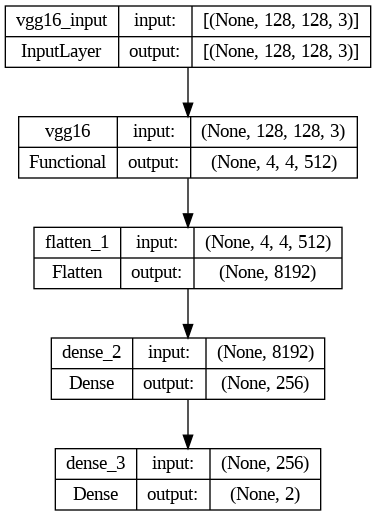

In [13]:
# Define the VGG model
def create_vgg_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (128, 128, 3)
num_classes = 2

vgg_model = create_vgg_model(input_shape, num_classes)

vgg_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

vgg_model.summary()
plot_model(vgg_model, to_file='vgg_model.png', show_shapes=True, show_layer_names=True)

In [14]:
# Train the VGG model
vgg_history = vgg_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
4/4 [==============================] - 3s 408ms/step - loss: 31.7690 - accuracy: 0.5100 - val_loss: 8.0503 - val_accuracy: 0.9000
Epoch 2/10
4/4 [==============================] - 0s 19ms/step - loss: 7.2304 - accuracy: 0.8300 - val_loss: 11.0790 - val_accuracy: 0.8500
Epoch 3/10
4/4 [==============================] - 0s 19ms/step - loss: 3.9674 - accuracy: 0.8700 - val_loss: 5.4572 - val_accuracy: 0.9500
Epoch 4/10
4/4 [==============================] - 0s 18ms/step - loss: 0.5601 - accuracy: 0.9700 - val_loss: 3.3899 - val_accuracy: 0.9500
Epoch 5/10
4/4 [==============================] - 0s 22ms/step - loss: 0.0509 - accuracy: 0.9900 - val_loss: 2.8156 - val_accuracy: 0.9000
Epoch 6/10
4/4 [==============================] - 0s 18ms/step - loss: 0.0369 - accuracy: 0.9900 - val_loss: 2.5478 - val_accuracy: 0.9000
Epoch 7/10
4/4 [==============================] - 0s 19ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.3067 - val_accuracy: 0.9000
Epoch 8/10
4/4 [========

In [15]:
vgg_model.save_weights('vgg_model_weights.h5')

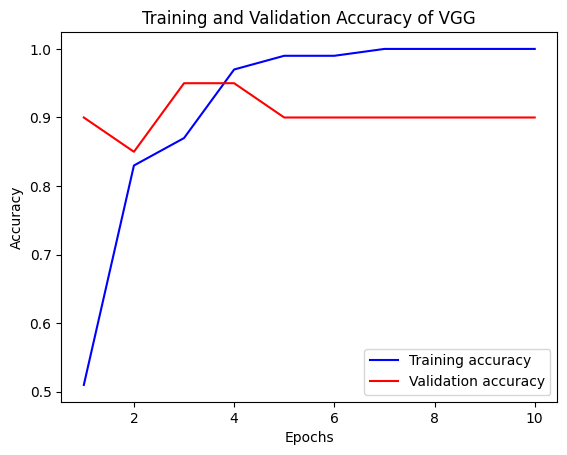

In [16]:
# Accessing accuracy values from the history
train_accuracy_vgg = vgg_history.history['accuracy']
val_accuracy_vgg = vgg_history.history['val_accuracy']

# Plotting the accuracy
epochs_vgg = range(1, len(train_accuracy_vgg) + 1)

plt.plot(epochs_vgg, train_accuracy_vgg, 'b', label='Training accuracy')
plt.plot(epochs_vgg, val_accuracy_vgg, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy of VGG')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# Evaluate the model on the testing data
test_loss, test_accuracy = vgg_model.evaluate(X_test, y_test)

# Print the testing accuracy
print("Testing Accuracy of VGG:", test_accuracy)

41/41 [==============================] - 1s 25ms/step - loss: 6.0262 - accuracy: 0.8520
Testing Accuracy of VGG: 0.852021336555481


# CNN

In [18]:
# A simple cnn model
input_shape = (128, 128, 3)
num_classes = 2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)      

In [19]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
4/4 [==============================] - 4s 184ms/step - loss: 37.3127 - accuracy: 0.4600 - val_loss: 5.8193 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 0s 15ms/step - loss: 2.5307 - accuracy: 0.5600 - val_loss: 0.7995 - val_accuracy: 0.4500
Epoch 3/10
4/4 [==============================] - 0s 14ms/step - loss: 0.4522 - accuracy: 0.8300 - val_loss: 0.6376 - val_accuracy: 0.7000
Epoch 4/10
4/4 [==============================] - 0s 14ms/step - loss: 0.3637 - accuracy: 0.8900 - val_loss: 0.4926 - val_accuracy: 0.7500
Epoch 5/10
4/4 [==============================] - 0s 14ms/step - loss: 0.3260 - accuracy: 0.8700 - val_loss: 0.4183 - val_accuracy: 0.8000
Epoch 6/10
4/4 [==============================] - 0s 14ms/step - loss: 0.2484 - accuracy: 0.9300 - val_loss: 0.4236 - val_accuracy: 0.8500
Epoch 7/10
4/4 [==============================] - 0s 14ms/step - loss: 0.1988 - accuracy: 0.9400 - val_loss: 0.3487 - val_accuracy: 0.8500
Epoch 8/10
4/4 [=========

In [20]:
model.save_weights('cnn_model_weights.h5')

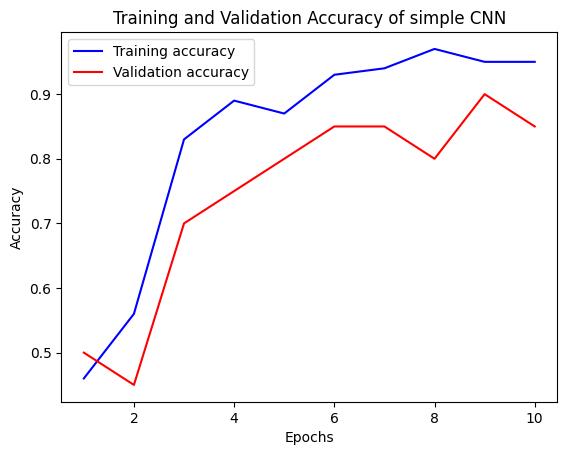

In [21]:
# Accessing accuracy values from the history
train_accuracy_model = model_history.history['accuracy']
val_accuracy_model = model_history.history['val_accuracy']

# Plotting the accuracy
epochs_model = range(1, len(train_accuracy_model) + 1)

plt.plot(epochs_model, train_accuracy_model, 'b', label='Training accuracy')
plt.plot(epochs_model, val_accuracy_model, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy of simple CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
# Evaluate the model on the testing data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the testing accuracy
print("Testing Accuracy of CNN:", test_accuracy)

41/41 [==============================] - 0s 6ms/step - loss: 0.4962 - accuracy: 0.8177
Testing Accuracy of CNN: 0.8176963925361633


# Siamese

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 25088)                93248     ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 tf.math.multiply (TFOpLamb  (None, 25088)                0         ['sequential_3[0][0]',    

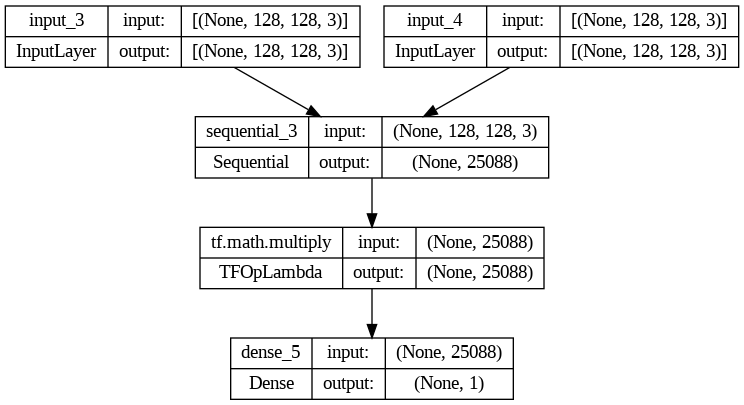

In [23]:
# Define Siamese network architecture
def create_siamese_model(input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Shared convolutional base
    conv_base = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten()
    ])

    # Encoding for input A and B
    encoded_a = conv_base(input_a)
    encoded_b = conv_base(input_b)

    # Compute Euclidean distance between the two encodings
    similarity_score = tf.multiply(encoded_a, encoded_b)

    # Fully connected layers for classification
    x = tf.keras.layers.Dense(1,activation='sigmoid')(similarity_score)

    # Siamese model
    model = Model(inputs=[input_a, input_b], outputs=x)
    return model

def contrastive_loss(y_true, distance):
    margin = 1
    square_pred = tf.square(distance)
    margin_square = tf.square(tf.maximum(margin - distance, 0))
    y_true = tf.cast(y_true, distance.dtype)  # Cast y_true to the same dtype as distance
    return tf.reduce_mean((1 - y_true) * square_pred + y_true * margin_square)

# Define image dimensions
input_shape = (128, 128, 3)  # Assuming resized images are 128x128 pixels

# Create Siamese model
siamese_model = create_siamese_model(input_shape)

# Display model summary
siamese_model.summary()
plot_model(siamese_model, to_file='siamese_model.png', show_shapes=True, show_layer_names=True)

In [24]:
# Prepare data for the Siamese network
def create_random_pairs(images, labels):
    pairs = []
    pair_labels = []
    for i in range(len(images)):
      for _  in range(10):
        positive_indices = np.where(labels == labels[i])[0]
        positive_idx = random.choice(positive_indices)
        pairs.append([images[i], images[positive_idx]])
        pair_labels.append(1)  # Positive pair label

        negative_indices = np.where(labels != labels[i])[0]
        negative_idx = random.choice(negative_indices)
        pairs.append([images[i], images[negative_idx]])
        pair_labels.append(0)  # Negative pair label

    return np.array(pairs), np.array(pair_labels)

# Prepare random pairs for each image
pairs_train, labels_train = create_random_pairs(X_train, y_train)
pairs_val, labels_val = create_random_pairs(X_val, y_val)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 4, 4, 2048)           2358771   ['input_5[0][0]',             
                                                          2          'input_6[0][0]']             
                                                                                                  
 flatten_4 (Flatten)         (None, 32768)                0         ['resnet50[0][0]',      

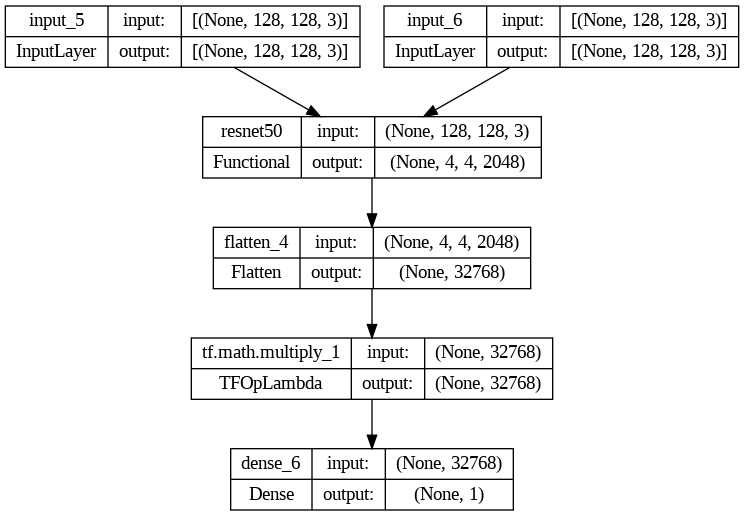

In [25]:
def create_siamese_model_resnet(input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Pre-trained ResNet50 model for feature extraction
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze ResNet50 layers
    for layer in resnet_base.layers:
        layer.trainable = False

    # Encoding for input A and B using ResNet50
    encoded_a = resnet_base(input_a)
    encoded_b = resnet_base(input_b)

    # Flatten the output of ResNet
    flatten_layer = Flatten()

    # Flatten the encoded features
    flattened_a = flatten_layer(encoded_a)
    flattened_b = flatten_layer(encoded_b)

    # Compute Euclidean distance between the two encodings
    similarity_score = tf.multiply(flattened_a, flattened_b)

    # Fully connected layers for classification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(similarity_score)

    # Siamese model
    model = Model(inputs=[input_a, input_b], outputs=x)

    return model

# Define image dimensions
input_shape = (128, 128, 3)  # Assuming resized images are 128x128 pixels

# Create Siamese model with ResNet50 base
siamese_model_resnet = create_siamese_model_resnet(input_shape)

# Display model summary
siamese_model_resnet.summary()
plot_model(siamese_model_resnet, to_file='siamese_model_resnet.png', show_shapes=True, show_layer_names=True)

In [26]:
# Compile the model
siamese_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Fit the Siamese model
siamese_history = siamese_model.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train, batch_size=32, epochs=30, validation_data=([pairs_val[:, 0], pairs_val[:, 1]], labels_val))

Epoch 1/30
63/63 [==============================] - 3s 18ms/step - loss: 45.9475 - accuracy: 0.5295 - val_loss: 0.7557 - val_accuracy: 0.5200
Epoch 2/30
63/63 [==============================] - 1s 8ms/step - loss: 0.6098 - accuracy: 0.6330 - val_loss: 0.7929 - val_accuracy: 0.5325
Epoch 3/30
63/63 [==============================] - 1s 9ms/step - loss: 0.5469 - accuracy: 0.7145 - val_loss: 0.7893 - val_accuracy: 0.5825
Epoch 4/30
63/63 [==============================] - 1s 8ms/step - loss: 0.4778 - accuracy: 0.7590 - val_loss: 1.0755 - val_accuracy: 0.5625
Epoch 5/30
63/63 [==============================] - 1s 9ms/step - loss: 0.3999 - accuracy: 0.8185 - val_loss: 1.0144 - val_accuracy: 0.5650
Epoch 6/30
63/63 [==============================] - 1s 8ms/step - loss: 0.3203 - accuracy: 0.8625 - val_loss: 1.2385 - val_accuracy: 0.5975
Epoch 7/30
63/63 [==============================] - 1s 9ms/step - loss: 0.2682 - accuracy: 0.8950 - val_loss: 1.5299 - val_accuracy: 0.5750
Epoch 8/30
63/63 [

In [27]:
# Compile the model
siamese_model_resnet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Fit the Siamese model
siamese_resnet_history = siamese_model_resnet.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train, batch_size=32, epochs=30, validation_data=([pairs_val[:, 0], pairs_val[:, 1]], labels_val))

Epoch 1/30
63/63 [==============================] - 9s 58ms/step - loss: 2.6646 - accuracy: 0.7840 - val_loss: 2.3403 - val_accuracy: 0.7825
Epoch 2/30
63/63 [==============================] - 1s 21ms/step - loss: 0.3431 - accuracy: 0.9410 - val_loss: 3.6874 - val_accuracy: 0.7825
Epoch 3/30
63/63 [==============================] - 1s 21ms/step - loss: 0.4612 - accuracy: 0.9335 - val_loss: 4.3962 - val_accuracy: 0.8050
Epoch 4/30
63/63 [==============================] - 1s 21ms/step - loss: 0.1217 - accuracy: 0.9795 - val_loss: 3.6210 - val_accuracy: 0.8025
Epoch 5/30
63/63 [==============================] - 1s 21ms/step - loss: 0.0364 - accuracy: 0.9900 - val_loss: 4.1630 - val_accuracy: 0.7925
Epoch 6/30
63/63 [==============================] - 1s 22ms/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 3.0890 - val_accuracy: 0.8000
Epoch 7/30
63/63 [==============================] - 1s 22ms/step - loss: 0.0870 - accuracy: 0.9810 - val_loss: 4.6192 - val_accuracy: 0.7675
Epoch 8/30
63

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 4, 4, 512)            1471468   ['input_8[0][0]',             
                                                          8          'input_9[0][0]']             
                                                                                                  
 flatten_5 (Flatten)         (None, 8192)                 0         ['vgg16[0][0]',         

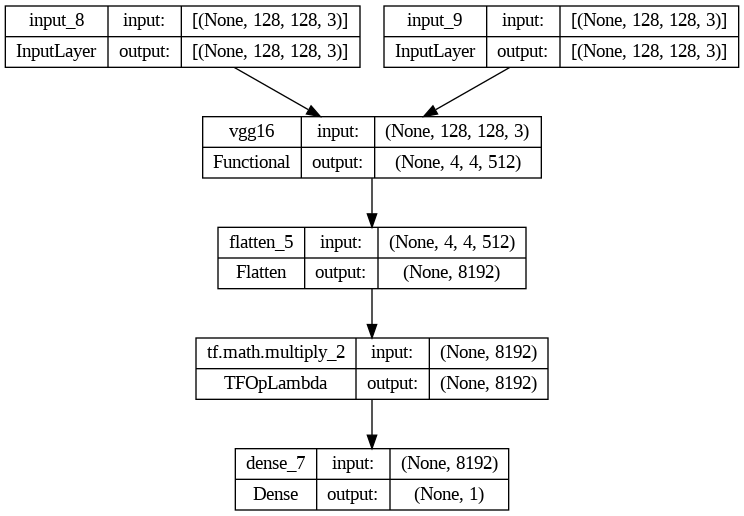

In [28]:
def create_siamese_model_VGG(input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Pre-trained ResNet50 model for feature extraction
    VGG_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze ResNet50 layers
    for layer in VGG_base.layers:
        layer.trainable = False

    # Encoding for input A and B using ResNet50
    encoded_a = VGG_base(input_a)
    encoded_b = VGG_base(input_b)

    # Flatten the output of ResNet
    flatten_layer = Flatten()

    # Flatten the encoded features
    flattened_a = flatten_layer(encoded_a)
    flattened_b = flatten_layer(encoded_b)

    # Compute Euclidean distance between the two encodings
    similarity_score = tf.multiply(flattened_a, flattened_b)

    # Fully connected layers for classification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(similarity_score)

    # Siamese model
    model = Model(inputs=[input_a, input_b], outputs=x)

    return model

# Define image dimensions
input_shape = (128, 128, 3)  # Assuming resized images are 128x128 pixels

# Create Siamese model with ResNet50 base
siamese_model_vgg = create_siamese_model_VGG(input_shape)

# Display model summary
siamese_model_vgg.summary()
plot_model(siamese_model_vgg, to_file='siamese_model_VGG.png', show_shapes=True, show_layer_names=True)

In [29]:
# Compile the model
siamese_model_vgg.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Fit the Siamese model
siamese_vgg_history = siamese_model_vgg.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train, batch_size=32, epochs=60, validation_data=([pairs_val[:, 0], pairs_val[:, 1]], labels_val))

Epoch 1/60
63/63 [==============================] - 4s 41ms/step - loss: 51.3152 - accuracy: 0.7210 - val_loss: 41.1464 - val_accuracy: 0.7250
Epoch 2/60
63/63 [==============================] - 1s 18ms/step - loss: 13.9651 - accuracy: 0.8505 - val_loss: 28.4700 - val_accuracy: 0.7400
Epoch 3/60
63/63 [==============================] - 1s 18ms/step - loss: 9.0542 - accuracy: 0.8965 - val_loss: 47.6192 - val_accuracy: 0.6925
Epoch 4/60
63/63 [==============================] - 1s 19ms/step - loss: 6.0514 - accuracy: 0.9085 - val_loss: 27.3428 - val_accuracy: 0.7850
Epoch 5/60
63/63 [==============================] - 1s 18ms/step - loss: 2.7817 - accuracy: 0.9445 - val_loss: 35.0311 - val_accuracy: 0.7525
Epoch 6/60
63/63 [==============================] - 1s 18ms/step - loss: 2.1069 - accuracy: 0.9430 - val_loss: 29.1700 - val_accuracy: 0.7850
Epoch 7/60
63/63 [==============================] - 1s 19ms/step - loss: 1.4925 - accuracy: 0.9605 - val_loss: 35.6651 - val_accuracy: 0.7525
Epoc

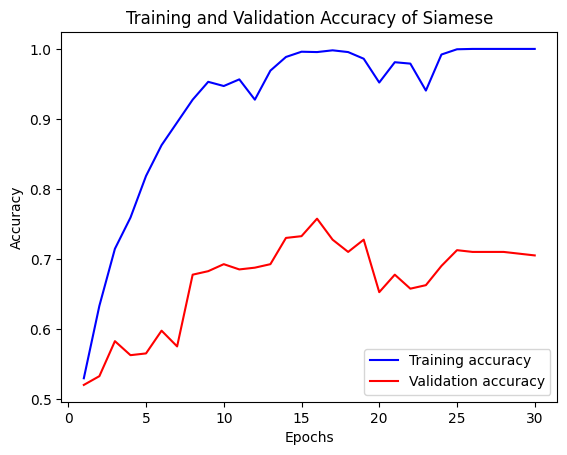

In [30]:
# Accessing accuracy values from the history
train_accuracy_siamese = siamese_history.history['accuracy']
val_accuracy_siamese = siamese_history.history['val_accuracy']

# Plotting the accuracy
epochs_siamese = range(1, len(train_accuracy_siamese) + 1)

plt.plot(epochs_siamese, train_accuracy_siamese, 'b', label='Training accuracy')
plt.plot(epochs_siamese, val_accuracy_siamese, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy of Siamese')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

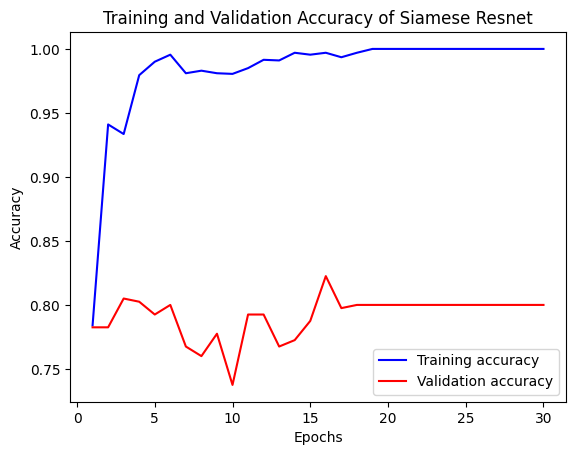

In [31]:
# Accessing accuracy values from the history
train_accuracy_siamese = siamese_resnet_history.history['accuracy']
val_accuracy_siamese = siamese_resnet_history.history['val_accuracy']

# Plotting the accuracy
epochs_siamese = range(1, len(train_accuracy_siamese) + 1)

plt.plot(epochs_siamese, train_accuracy_siamese, 'b', label='Training accuracy')
plt.plot(epochs_siamese, val_accuracy_siamese, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy of Siamese Resnet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

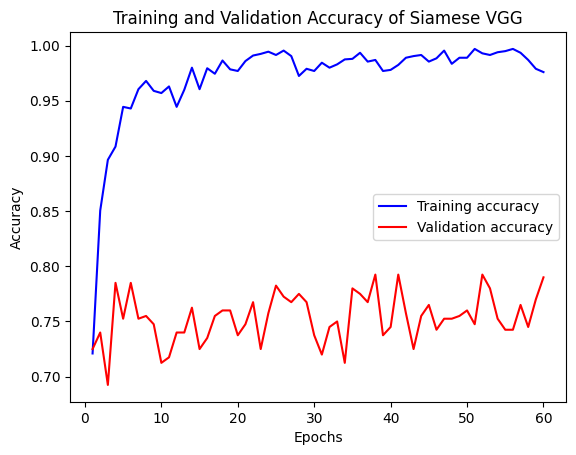

In [32]:
# Accessing accuracy values from the history
train_accuracy_siamese = siamese_vgg_history.history['accuracy']
val_accuracy_siamese = siamese_vgg_history.history['val_accuracy']

# Plotting the accuracy
epochs_siamese = range(1, len(train_accuracy_siamese) + 1)

plt.plot(epochs_siamese, train_accuracy_siamese, 'b', label='Training accuracy')
plt.plot(epochs_siamese, val_accuracy_siamese, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy of Siamese VGG')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
import random

# Function to generate pairs for a single image
def generate_pairs(test_image, train_images_tumor, train_images_notumor):
    pairs = []
    labels = []

    # Create pairs with tumor images
    for i in range(len(train_images_tumor)):
        train_image = train_images_tumor[i]
        pairs.append([test_image, train_image])
        labels.append(1)

    # Create pairs with notumor images
    for j in range(len(train_images_notumor)):
        train_image = train_images_notumor[j]
        pairs.append([test_image, train_image])
        labels.append(0)

    return np.array(pairs), np.array(labels)

# Initialize variables to store predictions
predictions = []
m = len(X_train)//2

# Iterate through each image in the testing set
for i in range(len(X_test)):
    # Generate pairs for the current test image
    pairs, _ = generate_pairs(X_test[i], X_train[:m], X_train[m:])

    # Predict similarity scores for the pairs
    similarity_scores = siamese_model.predict([pairs[:, 0], pairs[:, 1]])

    # Calculate mean similarity score for each class (tumor and notumor)
    mean_similarity_notumor = np.mean(similarity_scores[:m])
    mean_similarity_tumor = np.mean(similarity_scores[m:])


    # Make prediction based on mean similarity score
    if mean_similarity_notumor > mean_similarity_tumor:
        predictions.append(1)  # Notumor predicted
    else:
        predictions.append(0)  # Tumor predicted

    print(str(i)+": "+str(accuracy_score(y_test[:i], predictions[:i])))

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

4/4 [==============================] - 0s 3ms/step
0: nan
4/4 [==============================] - 0s 3ms/step
1: 1.0
4/4 [==============================] - 0s 3ms/step
2: 0.5


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4/4 [==============================] - 0s 3ms/step
3: 0.6666666666666666
4/4 [==============================] - 0s 3ms/step
4: 0.75
4/4 [==============================] - 0s 3ms/step
5: 0.8
4/4 [==============================] - 0s 3ms/step
6: 0.8333333333333334
4/4 [==============================] - 0s 3ms/step
7: 0.7142857142857143
4/4 [==============================] - 0s 3ms/step
8: 0.75
4/4 [==============================] - 0s 3ms/step
9: 0.7777777777777778
4/4 [==============================] - 0s 3ms/step
10: 0.8
4/4 [==============================] - 0s 3ms/step
11: 0.8181818181818182
4/4 [==============================] - 0s 3ms/step
12: 0.75
4/4 [==============================] - 0s 3ms/step
13: 0.7692307692307693
4/4 [==============================] - 0s 3ms/step
14: 0.7857142857142857
4/4 [==============================] - 0s 3ms/step
15: 0.8
4/4 [==============================] - 0s 4ms/step
16: 0.8125
4/4 [==============================] - 0s 3ms/step
17: 0.8235294117647

In [34]:
import random

# Function to generate pairs for a single image
def generate_pairs(test_image, train_images_tumor, train_images_notumor):
    pairs = []
    labels = []

    # Create pairs with tumor images
    for i in range(len(train_images_tumor)):
        train_image = train_images_tumor[i]
        pairs.append([test_image, train_image])
        labels.append(1)

    # Create pairs with notumor images
    for j in range(len(train_images_notumor)):
        train_image = train_images_notumor[j]
        pairs.append([test_image, train_image])
        labels.append(0)

    return np.array(pairs), np.array(labels)

# Initialize variables to store predictions
predictions = []
m = len(X_train)//2

# Iterate through each image in the testing set
for i in range(len(X_test)):
    # Generate pairs for the current test image
    pairs, _ = generate_pairs(X_test[i], X_train[:m], X_train[m:])

    # Predict similarity scores for the pairs
    similarity_scores = siamese_model_resnet.predict([pairs[:, 0], pairs[:, 1]])

    # Calculate mean similarity score for each class (tumor and notumor)
    mean_similarity_notumor = np.mean(similarity_scores[:m])
    mean_similarity_tumor = np.mean(similarity_scores[m:])


    # Make prediction based on mean similarity score
    if mean_similarity_notumor > mean_similarity_tumor:
        predictions.append(1)  # Notumor predicted
    else:
        predictions.append(0)  # Tumor predicted

    print(str(i)+": "+str(accuracy_score(y_test[:i], predictions[:i])))

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

4/4 [==============================] - 2s 18ms/step
0: nan
4/4 [==============================] - 0s 19ms/step
1: 1.0


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4/4 [==============================] - 0s 18ms/step
2: 0.5
4/4 [==============================] - 0s 18ms/step
3: 0.6666666666666666
4/4 [==============================] - 0s 18ms/step
4: 0.75
4/4 [==============================] - 0s 18ms/step
5: 0.8
4/4 [==============================] - 0s 18ms/step
6: 0.8333333333333334
4/4 [==============================] - 0s 17ms/step
7: 0.8571428571428571
4/4 [==============================] - 0s 16ms/step
8: 0.875
4/4 [==============================] - 0s 16ms/step
9: 0.8888888888888888
4/4 [==============================] - 0s 16ms/step
10: 0.9
4/4 [==============================] - 0s 16ms/step
11: 0.9090909090909091
4/4 [==============================] - 0s 16ms/step
12: 0.8333333333333334
4/4 [==============================] - 0s 17ms/step
13: 0.8461538461538461
4/4 [==============================] - 0s 17ms/step
14: 0.8571428571428571
4/4 [==============================] - 0s 16ms/step
15: 0.8666666666666667
4/4 [=========================

In [35]:
import random

# Function to generate pairs for a single image
def generate_pairs(test_image, train_images_tumor, train_images_notumor):
    pairs = []
    labels = []

    # Create pairs with tumor images
    for i in range(len(train_images_tumor)):
        train_image = train_images_tumor[i]
        pairs.append([test_image, train_image])
        labels.append(1)

    # Create pairs with notumor images
    for j in range(len(train_images_notumor)):
        train_image = train_images_notumor[j]
        pairs.append([test_image, train_image])
        labels.append(0)

    return np.array(pairs), np.array(labels)

# Initialize variables to store predictions
predictions = []
m = len(X_train)//2

# Iterate through each image in the testing set
for i in range(len(X_test)):
    # Generate pairs for the current test image
    pairs, _ = generate_pairs(X_test[i], X_train[:m], X_train[m:])

    # Predict similarity scores for the pairs
    similarity_scores = siamese_model_vgg.predict([pairs[:, 0], pairs[:, 1]])

    # Calculate mean similarity score for each class (tumor and notumor)
    mean_similarity_notumor = np.mean(similarity_scores[:m])
    mean_similarity_tumor = np.mean(similarity_scores[m:])


    # Make prediction based on mean similarity score
    if mean_similarity_notumor > mean_similarity_tumor:
        predictions.append(1)  # Notumor predicted
    else:
        predictions.append(0)  # Tumor predicted

    print(str(i)+": "+str(accuracy_score(y_test[:i], predictions[:i])))

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

4/4 [==============================] - 0s 15ms/step
0: nan
4/4 [==============================] - 0s 15ms/step
1: 1.0


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4/4 [==============================] - 0s 14ms/step
2: 1.0
4/4 [==============================] - 0s 14ms/step
3: 1.0
4/4 [==============================] - 0s 14ms/step
4: 1.0
4/4 [==============================] - 0s 13ms/step
5: 1.0
4/4 [==============================] - 0s 13ms/step
6: 1.0
4/4 [==============================] - 0s 13ms/step
7: 1.0
4/4 [==============================] - 0s 13ms/step
8: 1.0
4/4 [==============================] - 0s 13ms/step
9: 1.0
4/4 [==============================] - 0s 13ms/step
10: 1.0
4/4 [==============================] - 0s 13ms/step
11: 1.0
4/4 [==============================] - 0s 13ms/step
12: 0.9166666666666666
4/4 [==============================] - 0s 13ms/step
13: 0.9230769230769231
4/4 [==============================] - 0s 13ms/step
14: 0.9285714285714286
4/4 [==============================] - 0s 13ms/step
15: 0.9333333333333333
4/4 [==============================] - 0s 13ms/step
16: 0.9375
4/4 [==============================] - 0s 13m